In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from aum import DatasetWithIndex

import sys
sys.path.insert(0, "../")


/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_iq.dataiq_class import *
from src.models.neuralnets import *
from src.utils.data_loader import *
from src.utils.utils import *


In [3]:
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# UNDERSTANDING THE EVOLUTION OF DIFFERENT CLASSES

## Get data

In [4]:
dataset = "covid"

(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset)


## Train base model and assess training dynamics with Data-IQ

In [5]:
n_feats = X_train.shape[1]

LEARNING_RATE = 0.001
EPOCHS = 50  # train for longer as we want to show the dynamics over a long range

net = Net1(input_size=n_feats)
net.to(device)

checkpoint_list = []
ckpt_nets = []
losses = []
val_losses = []
dataiq_list = []


train_loader = DataLoader(
    dataset=DatasetWithIndex(train_data), batch_size=128, shuffle=True
)


criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


# Instantiate DATA-IQ
dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)
dataiq.on_epoch_end(net, device=device)
dataiq_list.append(dataiq)


# Train model
for e in range(1, EPOCHS + 1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch, sample_ids in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        sf = nn.LogSoftmax()
        y_pred = net(X_batch)

        _, predicted = torch.max(y_pred.data, 1)

        y_batch = y_batch.to(torch.int64)

        loss = criterion(sf(y_pred), y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

    # Log Data-IQ
    dataiq.on_epoch_end(net, device=device)

    print(
        f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
    )
    ckpt_nets.append(deepcopy(net))
    losses.append(epoch_loss / len(train_loader))
    dataiq_list.append(deepcopy(dataiq))

checkpoint_list.append(ckpt_nets)


/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
../src/models/neuralnets.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 001: | Loss: 0.69651 | Acc: 0.457
Epoch 002: | Loss: 0.69369 | Acc: 0.468
Epoch 003: | Loss: 0.68649 | Acc: 0.629
Epoch 004: | Loss: 0.64316 | Acc: 0.685
Epoch 005: | Loss: 0.59116 | Acc: 0.714
Epoch 006: | Loss: 0.57585 | Acc: 0.718
Epoch 007: | Loss: 0.56970 | Acc: 0.727
Epoch 008: | Loss: 0.56497 | Acc: 0.735
Epoch 009: | Loss: 0.56291 | Acc: 0.734
Epoch 010: | Loss: 0.56261 | Acc: 0.738
Epoch 011: | Loss: 0.56555 | Acc: 0.731
Epoch 012: | Loss: 0.56173 | Acc: 0.735
Epoch 013: | Loss: 0.55950 | Acc: 0.737
Epoch 014: | Loss: 0.55935 | Acc: 0.741
Epoch 015: | Loss: 0.55933 | Acc: 0.738
Epoch 016: | Loss: 0.56148 | Acc: 0.737
Epoch 017: | Loss: 0.55906 | Acc: 0.740
Epoch 018: | Loss: 0.55814 | Acc: 0.739
Epoch 019: | Loss: 0.55730 | Acc: 0.743
Epoch 020: | Loss: 0.55753 | Acc: 0.738
Epoch 021: | Loss: 0.56344 | Acc: 0.738
Epoch 022: | Loss: 0.55850 | Acc: 0.740
Epoch 023: | Loss: 0.56055 | Acc: 0.737
Epoch 024: | Loss: 0.55865 | Acc: 0.741
Epoch 025: | Loss: 0.55870 | Acc: 0.743


## Extract the subgroups

In [6]:
d_idx = 20  # final epoch
aleatoric_train = dataiq_list[d_idx].aleatoric
confidence_train = dataiq_list[d_idx].confidence
gold_probas = dataiq_list[
    d_idx
].gold_labels_probabilities  # probability of the true label

conf_thresh_high = 0.75
conf_thresh_low = 0.25
percentile_thresh = 50

hard_train = np.where(
    (confidence_train <= conf_thresh_low)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]
easy_train = np.where(
    (confidence_train >= conf_thresh_high)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence_train)):
    if id not in hard_easy:
        ambig_train.append(id)
ambig_train = np.array(ambig_train)


# Plot training dynamics

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


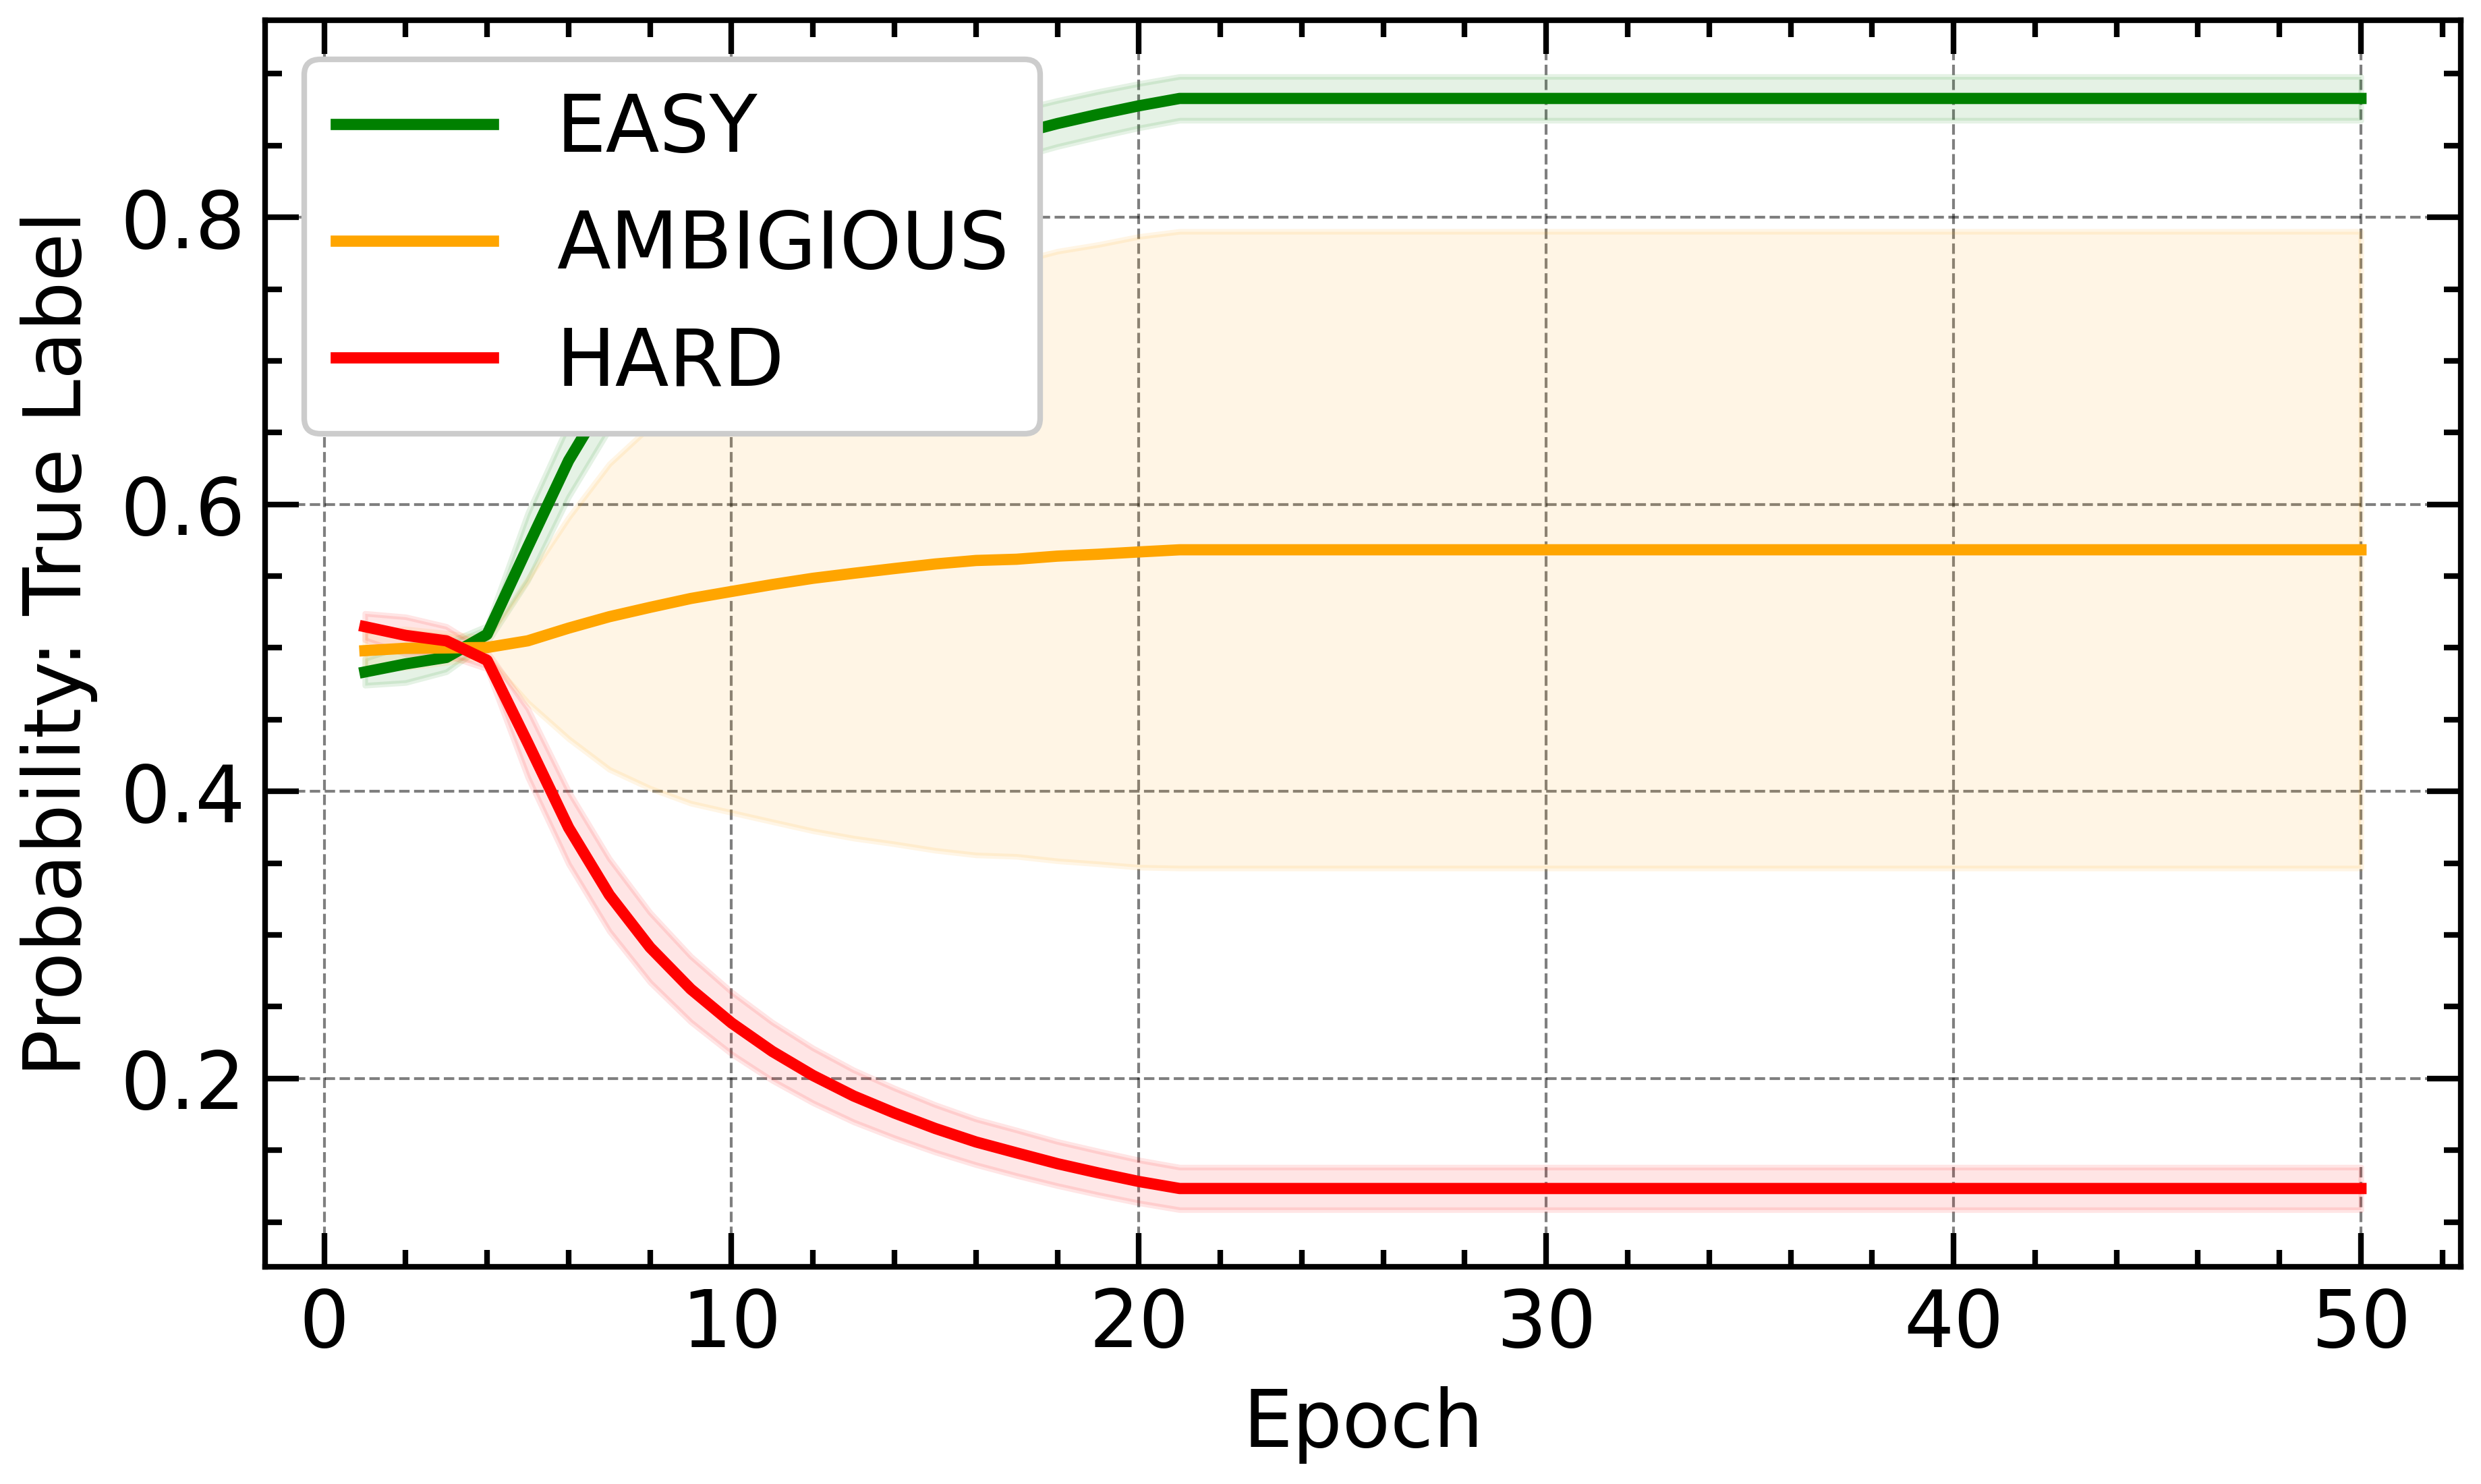

In [7]:
plt.figure(figsize=(7, 4))

epoch_acc = []
for i in range(0, len(dataiq_list)):
    preds = gold_probas[:, 0:i]
    acc = np.mean(preds, axis=-1)
    epoch_acc.append(acc)
epoch_acc = np.array(epoch_acc)

means = np.mean(epoch_acc[:, easy_train], axis=1)
stds = np.std(epoch_acc[:, easy_train], axis=1)
plt.plot(means, label="EASY", color="g")
plt.fill_between(
    range(len(dataiq_list)), means - stds, means + stds, alpha=0.1, color="g"
)

means = np.mean(epoch_acc[:, ambig_train], axis=1)
stds = np.std(epoch_acc[:, ambig_train], axis=1)
plt.plot(means, label="AMBIGIOUS", color="orange")
plt.fill_between(
    range(len(dataiq_list)), means - stds, means + stds, alpha=0.1, color="orange"
)

means = np.mean(epoch_acc[:, hard_train], axis=1)
stds = np.std(epoch_acc[:, hard_train], axis=1)
plt.plot(means, label="HARD", color="r")
plt.fill_between(
    range(len(dataiq_list)), means - stds, means + stds, alpha=0.1, color="r"
)

plt.xlabel("Epoch")
plt.ylabel("Probability: True Label")
plt.legend()
plt.show()
